# Brief summary of the software
### Second order differential equations
Consider the predator prey equations:
$$
\frac{dx}{dt} = x(1-x) - \frac{axy}{d+x} \\
\frac{dy}{dt} = by(1 - \frac{y}{x})
$$
for a=1, d=0.1, and b=0.1. The values of x and y at t=20 are plotted as a function of the initial value of x.


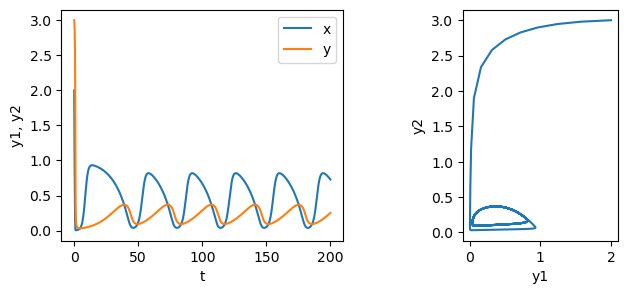

In [17]:
%matplotlib inline
import numpy as np
from SciComp.ivp import solve_ode
from SciComp.plotting import plot_phase_plane_2D

# Define ODE
def ode(t, y, a=1, d=0.1, b=0.1):
    x = y[0]
    y = y[1]
    return np.array([x*(1-x) - (a*x*y)/(d+x), b*y*(1 - y/x)])

# Initial conditions and step size
t0 = 0
y0 = np.array([2, 3])
tf = 200
deltat_max = 0.1

# Solve ODE
t, y = solve_ode(ode, t0, y0, tf=tf, method='RK4', deltat_max=deltat_max)
# Plot results
plot_phase_plane_2D(t, y)

### Periodic orbits
By intoducing a phase function, the time period of the periodic orbit and a set of initial conditions can be also be found as shown below:

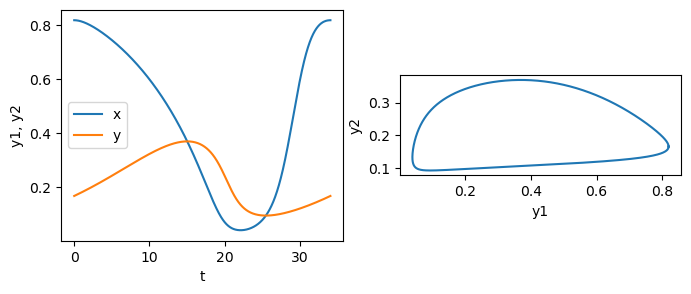

In [13]:
from SciComp.ivp import shooting

# Define the phase function and the condition
def phase_function(t, y):
    dx, dy = ode(t, y)
    return dx

# Apply shooting method to find X0 and T
U0 = np.array([0.6, 0.8, 35])              
X0, T = shooting(U0, ode, phase_function)

# Solve ODE to get time series
t, y = solve_ode(ode, 0, X0, tf=T, n_max=None, method='RK4', deltat_max=0.01)

plot_phase_plane_2D(t, y)

### Numerical continuation
Consider the algebraic equation:
$$
x^3 - x + c = 0
$$
Arc-length continuation can be used to determine the value of c as shown in the code snippet below.

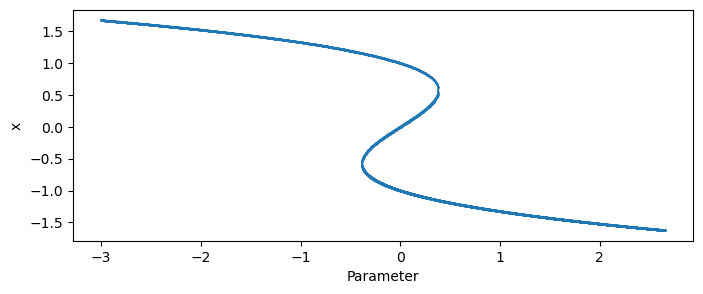

In [14]:
from SciComp.continuation import simple_continuation
from SciComp.plotting import plot_continuation
import matplotlib.pyplot as plt

func = lambda t, x, c: [t, x**3 - x + c]
x0 = 1
par0 = [-3]
vary_par = 0
step_size = 0.01
max_steps = 2000

x, par = simple_continuation(func, x0, par0, vary_par, step_size,
                             max_steps, method='arc-length continuation')

plot_continuation(par, x, xsixe=8, ysize=3)



### Boundary value problems

For example, take the following boundary value problem, the Bratu equation:

$$
D\frac{d^2u}{dx^2} + e^{\mu u} = 0, u(0) = u(1) = 0
$$
Where D is a constant and $\mu$ is a parameter. When $\mu$ is small, the solution can be approximated by the equation:
<!-- -1/2 * (x - a) * (x - b) + ((beta - alpha) / (b - a)) * (x - a) + alpha -->
$$
u(x) = \frac{-1}{2}(x-a)(x-b) + \frac{\beta-\alpha}{b-a}(x-a) + \alpha 
$$
Solving this in code is shown below:

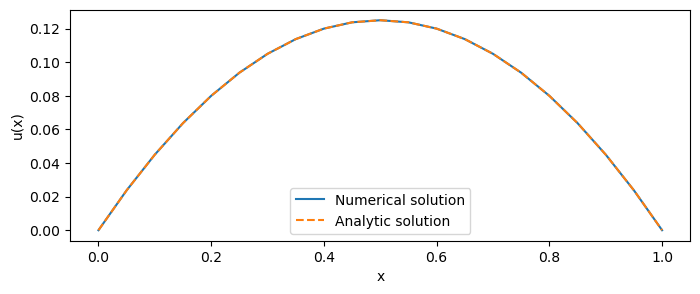

In [4]:
from SciComp.bvp import BVP
from SciComp.plotting import plot_bvp
import numpy as np

# Define BVP problem
a = 0
b = 1
N = 20
alpha = 0
beta = 0

def q(x, u, mu=0.01):
    return np.exp(mu*u)

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', q_fun=q, D=1)

u_guess = np.zeros(N-1)
u_linear, success = bvp.solve_ODE(u_guess, 'linear')

def u_analytic(x):
    return -1/2 * (x - a) * (x - b) + ((beta - alpha) / (b - a)) * (x - a) + alpha
u_analytical = u_analytic(bvp.x_values)

plot_bvp(bvp, u_linear, u_analytical)

Continuing with the Bratu problem, numerical continuation can be used to find the value of maximum value of $u$ as $\mu$ is increased. This is shown below:

C:\Users\duppu\Documents\EMAT3008-ScientificComputing\SciComp\bvp.py:119: UserWarning: The solver was not successful. The solution may not be accurate.
  warnings.warn('The solver was not successful. The solution may not be accurate.')


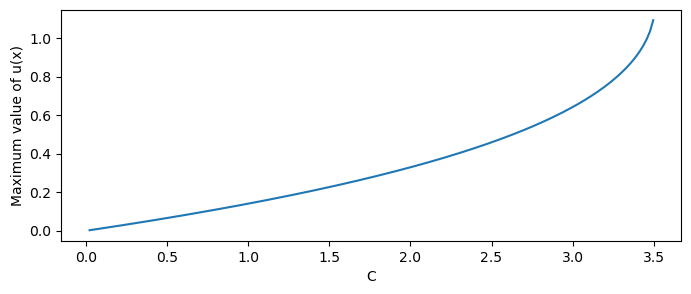

In [5]:
from SciComp.bvp import BVP
from SciComp.continuation import bvp_continuation
from SciComp.plotting import plot_max_u_vs_C
import numpy as np

# Re define q_fun to pass C as parameter
def q_base(x, u, C=0):
    return C*np.exp(u)
q_fun = lambda x, u: q_base(x, u, C)

bvp = BVP(a, b, N, alpha, beta, condition_type='Dirichlet', q_fun=q_fun, D=1)

# Perform continuation
Cs, all_u = bvp_continuation(bvp, 0, 4, 200, q_base) # Solver will not converge C > ~3.5

# Plot results
plot_max_u_vs_C(Cs, all_u)

### Partial differential equations
Solving the Fisher-KPP equation:
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + ru(1 - u)
$$
on the domain $0 \leq x \leq 10$. The boundary and initial conditions are:
$$
u(0, t) =1, \frac{\partial u}{\partial x}(10, t) = 0, u(x, 0) = 0$$
This is demonstrated below:

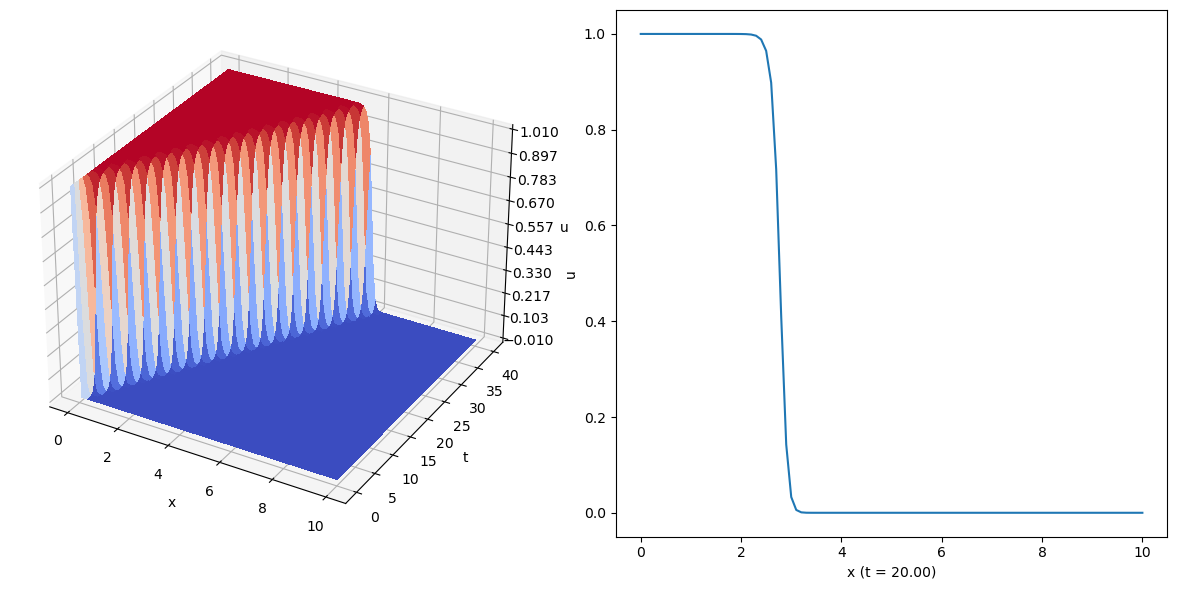

In [12]:
from SciComp.bvp import BVP
from SciComp.plotting import plot_PDE
import numpy as np

a = 0
b = 10
N = 100
alpha = 1
delta = 0
condition_type = 'Neumann'
D = 0.01

# Fisher-KPP problem
f_fun = lambda x, t: np.zeros(len(x))
q_fun = lambda x, u, r=2: r*u*(1-u)

bvp = BVP(a=a, b=b, N=N, alpha=alpha, delta=delta, condition_type=condition_type,
          D=0.01, f_fun=f_fun, q_fun=q_fun)
C = 0.2
t_boundary = 0
t_final = 40

u, t, dt, C = bvp.solve_PDE(t_boundary, t_final, C=C, method='Scipy Solver')

plot_PDE(bvp, u, t)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>
<br>

## Key software design decisions

### Architecture
The structure of the files can be visualised like in figure below:

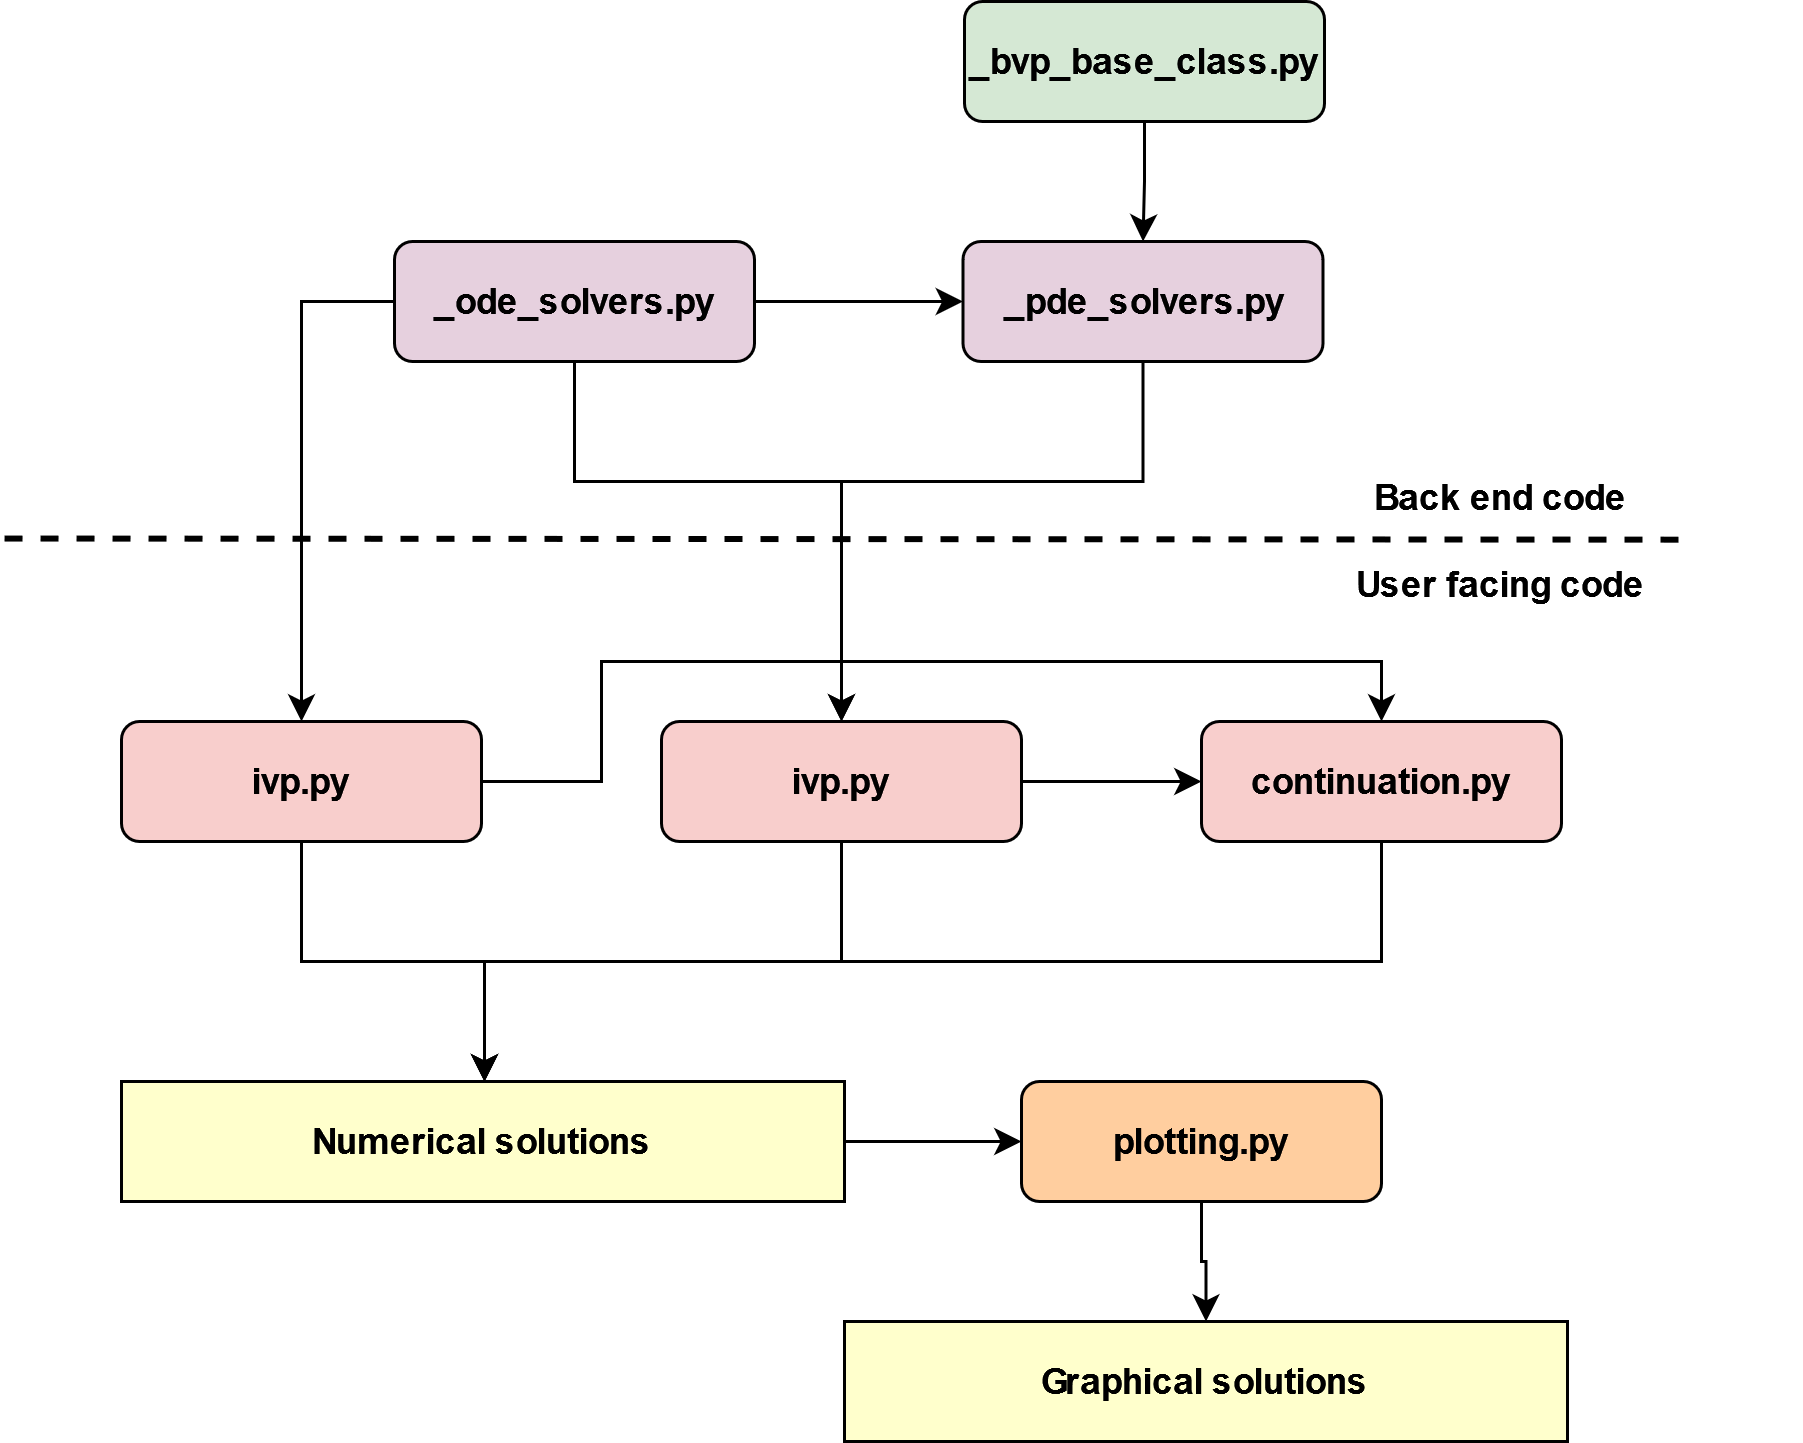

The architecture of the code is designed with a modular approach, breaking down the code into several files to enhance clarity and maintainability. The structure is organized into the following main divisions: Initial Value Problem (IVP) / Boundary Value Problem (BVP), Ordinary Differential Equation (ODE) / Partial Differential Equation (PDE), and User-Facing / Back-End components. Additional modules for continuation and plotting are provided to support further analysis and visualization.

#### User-Facing and Back-End Split

The User-Facing and Back-End split aims to minimize the amount of error handling required in the code and streamline the user experience. By separating these two aspects, the user-facing functions can focus on handling user inputs and validating them, while the back-end functions focus on the actual implementation of the algorithms. This separation allows the developer to control the user's interaction with the library and facilitates more efficient testing by reducing code repetition. Moreover, this design simplifies the steps for the user to obtain results, as they only need to provide input values to receive an output.

#### IVP/BVP Split

The IVP/BVP split is employed as the primary division in the user-facing code to account for the significant differences in the structure and nature of the problems. By providing separate files and functions for IVP and BVP, users can easily identify and utilize the appropriate methods for their specific problem, reducing potential confusion. The IVP and BVP files contain only the functions or classes that users will interact with directly.

#### ODE/PDE Split

The ODE/PDE split is implemented in the back-end to accommodate the distinct methods used to solve boundary value problems. Since BVPs can involve both ODEs and PDEs, this separation enables the BVP module to access and utilize the appropriate functions from both ODE and PDE files. This division also helps maintain a clean and organized structure in the back-end code.

#### Continuation and Plotting Modules

Continuation and plotting modules are incorporated to perform additional analysis and work in conjunction with the IVP and BVP files. These modules allow users to extend their problem-solving capabilities by offering tools for solution continuation and visualization. By providing these features, the library becomes more comprehensive and user-friendly, enabling users to gain deeper insights into their problem solutions.

#### ivp.py
The `ivp.py` file comprises two primary functions, solve_ode and shooting, which are designed to handle a wide range of user inputs gracefully. These functions provide user customization and flexibility, enabling users to tailor the solution process according to their specific problem requirements.

The `solve_ode` function serves as an interface to a collection of step functions from the `_ode_solvers.py` file. This design allows users to select the most suitable solver for their particular problem, providing a range of solution methods to choose from.

Similarly, the `shooting` function offers user customization by requiring both an ODE solver and a root solver to address the shooting problem. Although default functions are provided, users have the option to pass their own custom functions, enabling them to tailor the problem-solving process to their needs.

Both `solve_ode` and `shooting` functions feature comprehensive error messages that not only inform users about the issue but also provide detailed information on the erroneous variables, such as their values, types, and shapes, along with the expected values. This level of detail significantly enhances users' ability to debug their input and identify the source of the problem, facilitating a smoother problem-solving experience.

#### bvp.py
The `bvp.py` file is more complex than the `ivp.py` file, mainly due to the increased intricacies and conditions involved in defining boundary value problems. A key aspect of addressing these problems is the space discretization, which introduces numerous variables that are used frequently and unexpectedly throughout the calculations. To maintain clean code, minimize function sizes, and effectively store these values, a class structure is introduced.

Initially, the class consisted of over 1000 lines of code, making it challenging to locate specific functions associated with the class. To address this issue, all constructor functions related to boundary conditions and discretization were moved to the `_bvp_base_class.py` file. This file defines the base class model, which includes all back-end functions required by the user-facing functions. The base class is then imported into `bvp.py`, and the `BVP` object inherits its functions and properties, significantly reducing complexity and improving readability.

An alternative structure considered was creating separate `BVP_ODE` and `BVP_PDE` objects to further divide the class. Time discretization, currently available for ODE problems but not used, could be a specific PDE method. However, at this stage of the code's development, this additional division would only introduce complexity and confusion for users. This approach may be reconsidered if the joint class becomes too complex.

Within the top-most class, there are two primary methods: solve_ode and solve_pde. These methods act as function handlers, directing inputs to an array of functions located in `_ode_solvers` and `_pde_solvers`. Although users could call these functions directly with minimal extra steps, the function handlers provide a robust interface for user interaction and reduce the need for repetitive error handling in individual solvers. The back-end solvers are designed with standardized inputs and outputs, enabling a plug-and-play approach that simplifies future development and allows users to incorporate their custom solvers easily.

A notable feature of the `solve_pde` function is the ability to utilize individual step solvers from the `ivp.py` file in explicit methods for solving PDEs using the method of lines. This design enables easy switching between solvers, such as RK4, Euler, or Heun steps, offering users greater flexibility in solving their problems.

#### _bvp_base_class
The primary purpose of the class defined in the `_bvp_base_class` file is to construct the spatial and time domains of the boundary value problem. One of its most ingenious aspects is the handling of different boundary conditions in the constructors. For each boundary condition type, the size of the x arrays and the shapes of the solutions vary slightly.

Previously, the code was riddled with if-else statements, repeatedly verifying the boundary conditions to determine the correct size of solution arrays. However, the introduction of shape variables defined in the `construct_matrix` method significantly reduces the need for such repetition, streamlining the code and enhancing its readability.

The `_bvp_base_class` file also contains various error handling functions, addressing different aspects of the problem definition. These functions contribute to a more robust and user-friendly implementation, ensuring that users receive helpful feedback when encountering issues with their problem definitions.

## Code optimisation

#### ODE step functions
Some analysis was carried out to compare the accuracies and computational time between the different methods on a simple first order problem:

$x'(t) = x(t)$, with $x(0) = 1$ and calculate $x(1)$.

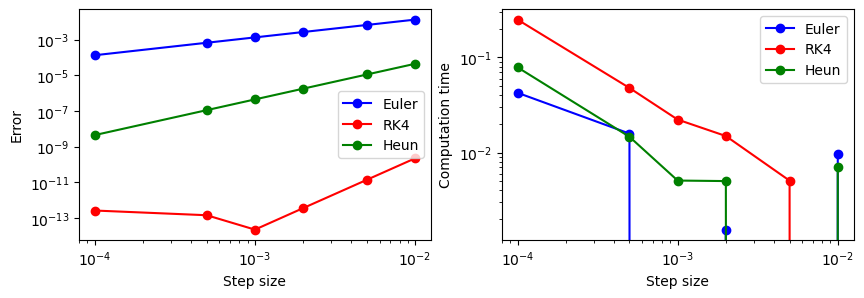

_________________________________________________________________________
Comparison of computation times and errors for a fixed step size (0.001):
Method:| Computation time (mag):| Error (mag):
-------|------------------------|-------------
Euler  |                    -inf|       -2.87
RK4    |                   -1.65|      -13.64
Heun   |                   -2.29|       -6.34
_________________________________________________________________________
Comparison of step size required to achieve a fixed magnitude error (-5):
Method:| Step size (mag):
-------|-----------------
Euler  |            -6.00
RK4    |            -1.00
Heun   |            -3.00


C:\Users\duppu\Documents\EMAT3008-ScientificComputing\SciComp\plotting.py:267: RuntimeWarning: divide by zero encountered in log10
  computation_time_mag = np.log10(computation_times[method][3])
C:\Users\duppu\Documents\EMAT3008-ScientificComputing\SciComp\plotting.py:278: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [7]:
from SciComp.plotting import run_comparison_diagnostics
run_comparison_diagnostics()

As can be seen from the graphs and diagnostic tables, the Euler method is the least accurate, but also the fastest. The Heun method is more accurate, but slower. The Runge-Kutta method is the most accurate, but also the slowest. However, the difference in magnitude of the error between RK4 and Heun is so much larger than the difference in computational cost that it is worth using RK4. As such, it has been set as the default method in the code. It can also be seen that with a step size lower than 0.001, the error begins to increase not decrease. It is likely that this is due to a truncation or rounding error from the computer's finite precision. This is not the case for the other methods, which continue to decrease in error as the step size decreases. As such, a warning has been put in for the runga kutta method. The user can choose to use Heun or Euler if they wish. For less complicated problems, Euler may be sufficient.

#### BVP ODE solver comparison
Consider the Bratu problem:
$$
D \frac{d^2 u}{d x^2} + e^{\mu x} = 0
$$
where $D = 1$, $\mu = 0.1$ and $u(0) = u(1) = 0$. A comparison was made between the different ODE solvers for this problem. The results are shown below:

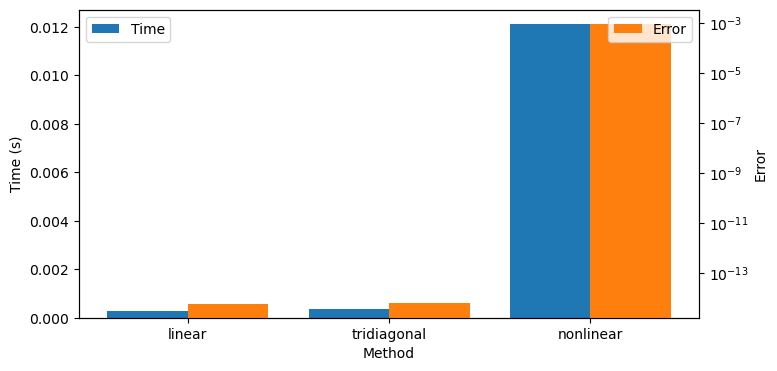

In [8]:
from SciComp.plotting import run_comparison_ode_solvers
run_comparison_ode_solvers()

#### BVP PDE solver comparison
Consider the linear diffusion equation:
$$
\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}
$$
with boundary conditions $u(0,t)=0$ and $u(1,t)=0$ and initial condition $u(x,0)=sin⁡(πx)$. A comparison of accuracies and computation time can be carried out for the different methods. The computation time is the time taken to calculate up to t=2. The accuracy is compared to the known value of $u(0.5,2)$, which is equal to $exp⁡(−0.2\pi^2)$. The results can be seen below:

C:\Users\duppu\Documents\EMAT3008-ScientificComputing\SciComp\_bvp_base_class.py:396: UserWarning: C = D * dt / dx^2 = 160.0 > 0.5. The solution may be unstable.
  warnings.warn('C = D * dt / dx^2 = {} > 0.5. The solution may be unstable.'.format(C))


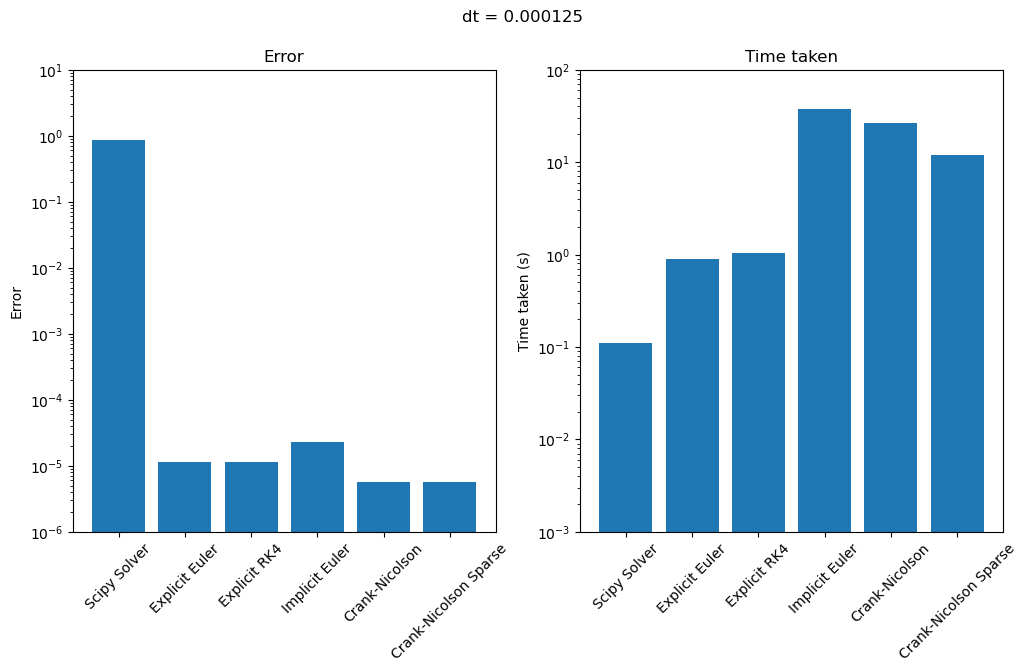

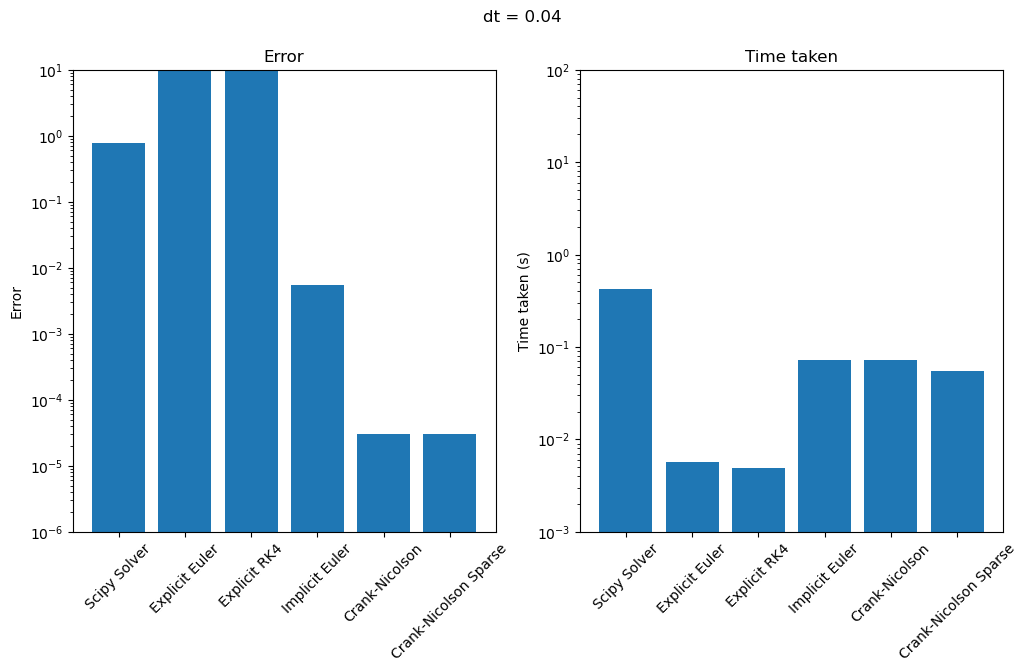

In [9]:
from SciComp.plotting import run_comparison_pde_solvers

run_comparison_pde_solvers()

For a very low timestep, all of the methods (apart from the Scipy Solver) perform very well, with the explicit methods out performing the implicit methods. However, as the timestep increases, the explicit methods become unstable and whilst the implicit methods only marginally decrease in accuracy. The Crank-Nicolson method is the most accurate, but also quite slow, especially for th smaller timesteps. This has led to Crank-Nicolson being used as the default values for the PDE solver. However, the user can choose to use the other methods if they wish.

#### Sparse matrices
An investigation was carried out to see if the use of sparse matrices would improve the computation time of the code. The results can be seen below:

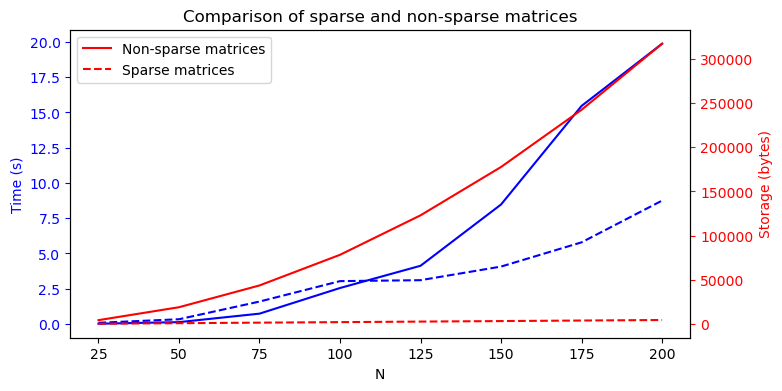

In [10]:
from SciComp.plotting import sparse_diagnostics
sparse_diagnostics()

As cab be seen, the amount of storage saving is astronomical and the time reduction in computation is also significantly reduced as N increases. As such, sparse matrices are used when possible in the code.

## Reflective learning log

### Navigating the Trade-Off: Feature Implementation Versus Robustness

Throughout the development of my Python library, I faced a critical trade-off between implementing numerous features and ensuring that each feature was fully robust and working. Striking the right balance between these two aspects was crucial, as attempting to implement too many features could compromise the overall quality and reliability of the library.

Due to the limited timeframe for this project, I decided to prioritize robustness and functionality over the sheer number of features. While this choice meant that I could not implement all the desired elements, it allowed me to focus on perfecting the existing features and making them as reliable as possible. This approach helped me deliver a high-quality library that users can trust and depend on, rather than a library with a multitude of features but questionable reliability.

In retrospect, I believe that this decision was the right one, as it has helped me create a more polished and reliable end product. If I were to start the unit over again, I would continue to prioritize robustness and functionality over quantity. In future projects, I will keep in mind the importance of balancing feature implementation with ensuring each feature's robustness, in order to deliver high-quality software within the constraints of time and resources.

### Exploring Scipy Functions: Enhancing Algorithm Understanding and Software Engineering Skills
During the development of my Python library for mathematical algorithms, I delved into the documentation and source code of various industry-standard libraries, specifically focusing on Scipy functions such as **solve_bvp** for solving boundary value problems and **lstsq** for addressing numerical ill-conditioning. This allowed me to not only learn more about the algorithms and their implementation but also to improve my software engineering skills by examining how to build complex classes and functions.

Previously, I had considered these libraries as black boxes, but examining their source code offered valuable insights into the core Python language and its numerous features. This knowledge has already proven beneficial in my other modules, including my dissertation. In the short-term, this deeper understanding of Scipy functions will be useful for completing this unit and enhancing my programming skills. Long-term, it will help me contribute to open-source projects or even develop my own high-quality libraries.

If I were to start the unit over again, I would begin by exploring various libraries and their source code earlier on, with a particular focus on Scipy functions such as **solve_bvp** and **lstsq**, to maximize the benefits of learning from well-designed code. In the future, I will be more proactive in studying existing libraries and their implementation, while also applying critical thinking and questioning techniques to continually improve my software engineering abilities.

### Embracing Effective Version Control: Lessons from GitHub

During this module, I gained a deeper understanding of version control using GitHub. Although I was already familiar with the platform, learning to use it correctly presented challenges. At the beginning of the module, I made the mistake of making significant changes without committing them at intermediate stages. This led me to a situation where I was stuck between two versions, with working but unrecoverable code inbetween.

I learned that it's important to commit at the end of any section of newly working code, rather than waiting for the end of the day or the end of a session. This approach not only helps in version control but also significantly improves group collaboration. High-frequency, low-content commits make it easier to integrate changes with the work of others, reducing the likelihood of merge conflicts.

In the short-term, embracing effective version control practices has helped me manage my code more efficiently, avoiding potential setbacks. In the long-term, this knowledge will be valuable for collaborative projects, where proper version control is essential for seamless integration of code and maintaining a streamlined workflow.

If I were to start the unit over again, I would focus on developing good version control habits from the beginning. In the future, I will prioritize frequent, small commits to ensure that my code is easily manageable and less prone to conflicts, both for myself and any collaborators.

### The Importance of Code Documentation: Enhancing Clarity and Code Quality

In the early stages of the project, I found myself eager to write code as quickly as possible, focusing on completing tasks rather than maintaining clarity. However, I soon realized the value of taking the time to review my work and ensure proper documentation for every function. By adding detailed descriptions of the processes, defining the parameters and their types, and specifying the expected return values, I created a more coherent and easily understandable codebase.

Taking the time to document my code also provided an opportunity to re-read and double-check that it carried out the necessary processes, ensuring it took in the correct variables and produced the desired output. This practice not only improved the overall quality of my code but also facilitated a deeper understanding of the implemented algorithms and their nuances.

In the short-term, focusing on code documentation has helped me maintain a clear, organized, and efficient codebase. Long-term, it will be useful for future collaborations or open-source contributions, where well-documented code is crucial for effective communication among team members.

### Leveraging Unit Tests: Ensuring Robustness and Streamlining Debugging

At the beginning of the project, I focused on writing numerous unit tests to ensure consistent types and values for all variables. This approach allowed me to handle errors gracefully and create a robust system. However, when implementing a new feature, I encountered frequent errors that, despite clear messages, were not always easy to trace back to their source. To address this, I updated the error catching to provide more specific information about the variables causing the error, such as their exact shape and values. This enhancement streamlined the debugging process and enabled me to successfully implement the new feature.

In addition to variable checks, I also created tests to compare the outputs of my code against known outcomes. These tests proved invaluable, as they allowed me to make changes to different parts of my code without worrying about inadvertently breaking something. By running the unit tests, I could quickly identify any issues while the changes were still fresh in my mind, rather than discovering them weeks later when the code no longer worked as expected.

In the short-term, using unit tests has improved the robustness of my code and facilitated an efficient debugging process. In the long-term, this practice will help me maintain a high-quality codebase and ensure that my work remains reliable and accurate. If I were to start the unit over again, I would continue to prioritize writing and refining unit tests from the outset. In the future, I will rely on this approach to safeguard my code and ensure its reliability, both for myself and any collaborators

### Balancing Testing Efforts: Focusing on User-Facing Functions for Robustness

While extensive testing is crucial for ensuring code reliability, it can become a never-ending process, consuming a significant amount of time and potentially hindering development. In the real world, striking a balance between comprehensive testing and maintaining project viability is essential. To address this, I concentrated my efforts on making the user-facing functions as robust as possible.

By focusing on user-facing functions, I aimed to create a codebase that is resistant to errors when users interact with it. The goal was to design an initial error checking system that, once passed, would lead to a structured code execution that would not produce errors. This approach allowed me to avoid repeating the same tests multiple times and instead direct my attention towards enhancing the overall user experience.

In the short-term, this strategy has improved the reliability of my code while keeping development on track. In the long-term, it will contribute to a more robust and user-friendly library that can be confidently used by others. If I were to start the unit over again, I would continue to prioritize testing user-facing functions to strike the right balance between thoroughness and development efficiency. In the future, I will apply this balanced approach to other projects, ensuring that my code remains both reliable and economically viable.